[Markdown cheatsheet](https://daringfireball.net/projects/markdown/syntax)

# Analysis of Discourse Macrostructure in Schizophrenia: a Corpus Study
__Ryazanskaya Galina,
    Center for Language and Brain, HSE__

## my plans

[my secrert plan for this project and more](https://docs.google.com/document/d/1GATeTSyHrhbg5M_5hWci77V3ys_P0gS8KzdyQY1JNLE/edit)

The corpus of Russian internet language I am using is called RuWac. Here I have a link: 
[RuWac about](https://bitbucket.org/kostialopuhin/russe)

I also provide a link for direct download of the corpus archive (9GB): 
[RuWac](http://corpus.leeds.ac.uk/tools/ru/ruwac-parsed.out.xz)

### let us now do the things we will repeat many times as we work

In [8]:
import gensim
import logging
import lzma
import os
import random
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
from datetime import datetime
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from progressbar import progressbar
from sklearn import svm
from sklearn.exceptions import UndefinedMetricWarning
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut, cross_val_score, GridSearchCV, train_test_split
from string import punctuation as punct
from string import ascii_letters as latin
punct += '»«'

warnings.simplefilter('ignore', UndefinedMetricWarning)

corpus_archive_filename = 'ruwac-parsed.out.xz'
corpus_filename = 'corpus.txt'
premodel_filename = 'small.model'
vocabulary_filename = 'freq.txt'
model_filename = 'full.model'
sample_directory = 'sample'
manual_filename = 'manual_metrics.csv'
df_filename = 'df.csv'

## let us run the training on the full corpust text now

In [9]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

__we can load the model__

In [2]:
model = gensim.models.Word2Vec.load(model_filename)

In [5]:
model.wv['боль'][:10]

array([ 0.18733771,  0.15241444, -0.23210564, -0.00716051,  0.11090621,
       -0.16710451,  0.13207288,  0.03062673,  0.1780331 , -0.37367314],
      dtype=float32)

In [6]:
list(model.wv.vocab.items())[:10]

[('обвал', <gensim.models.keyedvectors.Vocab at 0xbf45fda518>),
 ('внут-ри', <gensim.models.keyedvectors.Vocab at 0xbf45fda5c0>),
 ('яйценосный', <gensim.models.keyedvectors.Vocab at 0xbf45fda5f8>),
 ('безок', <gensim.models.keyedvectors.Vocab at 0xbf45fda630>),
 ('…за', <gensim.models.keyedvectors.Vocab at 0xbf45fda668>),
 ('бункать', <gensim.models.keyedvectors.Vocab at 0xbf45fda6a0>),
 ('шр', <gensim.models.keyedvectors.Vocab at 0xbf45fda6d8>),
 ('башкиргаз', <gensim.models.keyedvectors.Vocab at 0xbf45fda710>),
 ('малус', <gensim.models.keyedvectors.Vocab at 0xbf45fda748>),
 ('6-7', <gensim.models.keyedvectors.Vocab at 0xbf45fda780>)]

In [7]:
model.most_similar(positive=['шизофрения'], negative=[], topn=10)

c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('психоз', 0.8883427381515503),
 ('аутизм', 0.8820264339447021),
 ('заикание', 0.8736182451248169),
 ('паранойя', 0.8727930784225464),
 ('неизлечимый', 0.8705182075500488),
 ('склероз', 0.8682988286018372),
 ('невроз', 0.8634791374206543),
 ('анорексия', 0.8620558977127075),
 ('невротический', 0.8593586683273315),
 ('клинически', 0.8593352437019348)]

## let us prepare the texts from the sample

__the sample consists of__ 

+ 9 outpatients diagnosed with schizophrenia
+ 10 controls from Russian Clinical Pear Stories Corpus (CliPS)

the original CliPS corpus contains pear film [Chafe, Freedle, & Bois, 1980](http://www.lattice.cnrs.fr/IMG/pdf/DuBois_1980_Beyond_Definiteness_L.pdf) retellings from people with aphasia, traumatic brain injuries, as well as healthy controls

the files contain already lemmatized texts with \n separated sentences (discourse units)

In [11]:
sample = {'control': {}, 'schizo': {}}

for filename in os.listdir(sample_directory):
    file_path = sample_directory + '/' + filename
    name = filename.strip('.txt')
    with open(file_path, 'r', encoding='utf-8') as file:
        raw_sent = file.readlines()
    sent = []
    for raw in raw_sent:
        sent.append(raw.strip().split())
    if 'H' in filename:
        sample['control'][name] = sent
    elif 'S' in filename:
        sample['schizo'][name] = sent

let us ensure that it works

In [12]:
sample['control']['HP-03']

[['вот', 'нет', 'текст'],
 ['это', 'так', 'задумать', 'да'],
 ['ну', 'я', 'думать', 'что', 'это', 'такой', 'такой', 'сюжетик', 'фильм'],
 ['значит',
  'это',
  'где',
  'то',
  'южный',
  'страна',
  'может',
  'мексика',
  'может',
  'что'],
 ['человек', 'там'],
 ['дело',
  'в',
  'то',
  'что',
  'это',
  'не',
  'на',
  'свой',
  'участок',
  'видно',
  'человек',
  'собирать',
  'урожай',
  'груша'],
 ['большой',
  'груша',
  'стоять',
  'дикий',
  'ну',
  'большой',
  'такой',
  'полноценный',
  'груша',
  'не',
  'дичка',
  'какой',
  'то',
  'там',
  'вот'],
 ['и', 'в', 'общем', 'должен', 'быть', 'три', 'корзина', 'нагрузить', 'вот'],
 ['ну',
  'в',
  'один',
  'момент',
  'он',
  'значит',
  'сделать',
  'с',
  'один',
  'груша',
  'видно',
  'как',
  'благодарность',
  'этот',
  'груша',
  'что',
  'они',
  'он',
  'может',
  'бесплатно',
  'доставаться',
  'он',
  'сделать',
  'ритуал'],
 ['вытереть', 'один', 'груша', 'свой', 'шейный', 'платок', 'вот'],
 ['потом', 'подъехать'

let us create a pandas dict for our metrics

In [13]:
patient_df = pd.read_csv(df_filename).drop('Unnamed: 0', axis=1)

In [16]:
patient_df

,ID,group,diagnosis,num_utt,man_gcoh,man_av_gcoh,man_compl_viol,man_compl_viol_per_utt,man_lcoh,man_av_lcoh,last_cum_tan,av_cum_tan,av_loc_coh
0,SP-01,schizo,1,26,112,4.307692,0.0,0.000000,97,3.730769,0.893185,0.886196,0.809226
1,SP-02,schizo,1,17,67,3.941176,3.0,0.176471,61,3.588235,0.915624,0.867483,0.817666
2,SP-03,schizo,1,20,84,4.200000,2.0,0.100000,69,3.450000,0.827491,0.851275,0.772379
3,SP-04,schizo,1,19,83,4.368421,1.0,0.052632,70,3.684211,0.757857,0.878585,0.812038
4,SP-05,schizo,1,9,27,3.000000,4.0,0.444444,22,2.444444,0.684295,0.686679,0.702189
5,SP-06,schizo,1,37,179,4.837838,0.0,0.000000,146,3.945946,0.939009,0.862357,0.796729
6,SP-07,schizo,1,50,206,4.120000,1.0,0.020000,156,3.120000,0.900677,0.888426,0.822227
7,SP-08,schizo,1,31,139,4.483871,0.0,0.000000,113,3.645161,0.758407,0.888702,0.819190
8,SP-09,schizo,1,35,127,3.628571,2.0,0.057143,119,3.400000,0.842130,0.874598,0.816834
9,HP-03,control,0,35,135,3.857143,0.0,0.000000,128,3.657143,0.918762,0.902152,0.847240


## TF-IDF
let us create a tf-idf model <br>
we will use words from sample as its dictionary <br>
we will first 100000 sentences of the corpus as the training text <br>

we will later use idf for weighting the vectors

__let us load a dictionary of idfs of the words from our sample__

In [17]:
idfs = {}
with open('idfs.txt', 'r', encoding='utf-8') as file:
    for line in file:
        key, str_val = line.split()
        idfs[key] = float(str_val)

let us see how it looks now

In [18]:
list(idfs.items())[25:35]

[('груша', 9.641392345549054),
 ('дело', 6.149030451809454),
 ('на', 2.834753223576036),
 ('не', 2.3682998231240004),
 ('свой', 4.642824301042186),
 ('собирать', 9.45880093227058),
 ('урожай', 12.033709768327814),
 ('участок', 10.53120942779863),
 ('большой', 6.784201219064748),
 ('дикий', 10.53120942779863)]

<h2>let us finally apply the metrics</h2>

see [Glosser & Desser, 1990](https://doi.org/10.1016/0093-934X(91)90117-J)

- __Tangentiality__ (see [Elvevåg et al 2017](https://academic.oup.com/schizophreniabulletin/article/43/3/509/3574458))
- __Local coherence__ (see [Wright, Capilouto, & Koutsoftas, 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3799984/))
- __Global coherence__ (see [Coelho & Flewellyn, 2003](https://doi.org/10.1080/729255216))
- __Violations of completeness__ (see [Christiansen, 1995](https://doi.org/10.1006/brln.1995.1062))

### let us get an idf-weighted average vector for each clause in a file

In [19]:
def get_file_clause_vectors(clauses):
    clauses_array = []
    for clause in clauses:
        clause_vect_array = []
        clause_idf_array = []
        for word in clause:
            try:
                vect = model.wv[word]
                idf = idfs[word]
            except KeyError:
                with open('words_not_found.txt', 'w', encoding='utf-8') as f:
                    f.write(word+'\n')
                continue
            if idf:
                clause_vect_array.append(vect)
                clause_idf_array.append(idf)
            else:
                continue
        if clause_idf_array:
            clause_vector = np.average(clause_vect_array, weights=clause_idf_array, axis=0)
            clauses_array.append(clause_vector)
        else:
            continue
    return(clauses_array)

here I will redifine cosine similarity because I am retarded

In [20]:
def cos_sim(v1, v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

In [28]:
def random_color():
    return "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])

<h3>Tangentiality</h3>
<ul>
    <li>cumulative tangentiality<br>
        a plot: <br>
        x axis: distance between the clauses (measured in clauses or words) <br>
        y axis: cosine distance between an averaged vector of the first <i>n</i> clauses and the current clause
</ul>

In [22]:
def get_cumulative_tangentiality_array(clauses):
    clause_vectors = get_file_clause_vectors(clauses)
    cumulative_tangentiality_array = []
    for i in range(len(clause_vectors)):
        if i:
            cumulative_tangentiality_array.append(
                cos_sim(np.mean(clause_vectors[:i], axis=0), clause_vectors[i]))
    return [1/x for x in cumulative_tangentiality_array]

Text(0.5, 1.0, 'cumulative tangentiality of control texts')

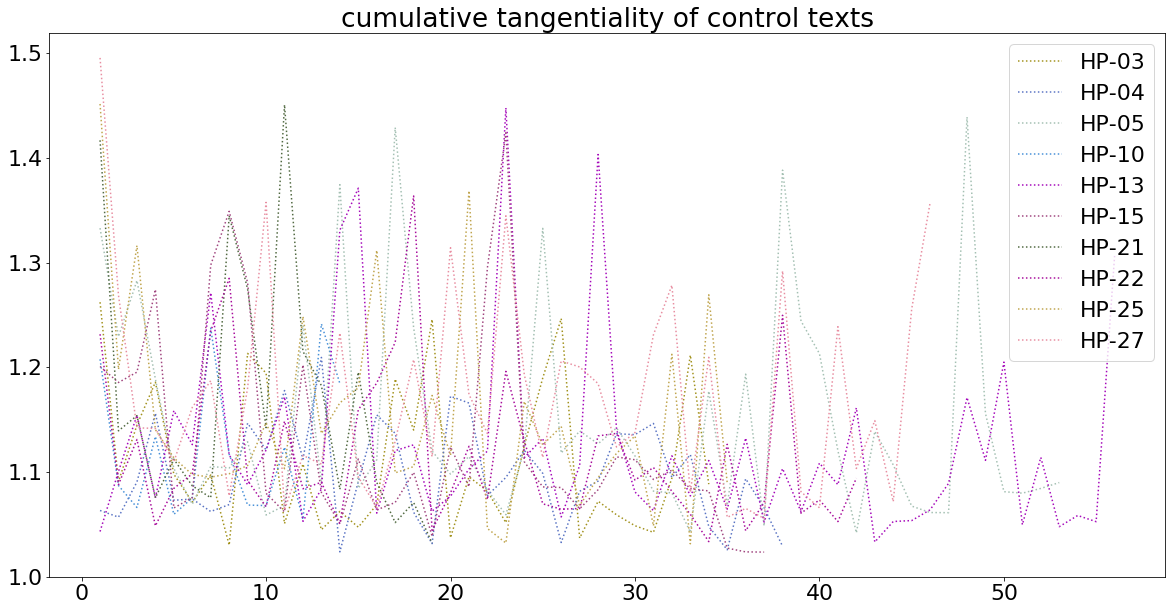

In [30]:
for filename in sample['control']:
    file = sample['control'][filename]
    file_sim = get_cumulative_tangentiality_array(file)
    plt.plot(np.arange(len(file_sim))+1, file_sim, color=random_color(), label=filename, linestyle=':')
plt.legend()
plt.rcParams.update({'font.size': 22, 'figure.figsize':[20,10]})
plt.title(label='cumulative tangentiality of control texts')

Text(0.5, 1.0, 'cumulative tangentiality of schizo texts')

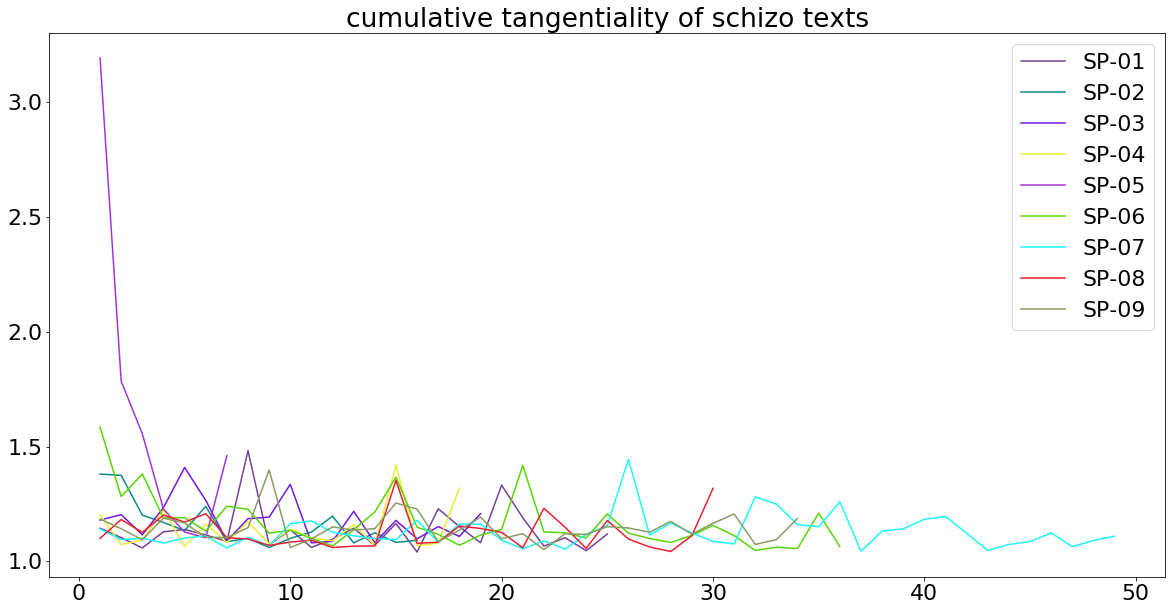

In [31]:
for filename in sample['schizo']:
    file = sample['schizo'][filename]
    file_sim = get_cumulative_tangentiality_array(file)
    plt.plot(np.arange(len(file_sim))+1,file_sim, random_color(), label=filename, linestyle='-')
plt.legend()
plt.rcParams.update({'font.size': 22, 'figure.figsize':[20,10]})
plt.title(label='cumulative tangentiality of schizo texts')

__let us now average sample texts and plot them__

In [24]:
def average_text_vector_dict(array_of_arrays):
    max_len = max([len(x) for x in array_of_arrays])
    result_dict = {'min':[],'med':[],'max':[]}
    for i in range(max_len):
        current = []
        for arr in array_of_arrays:
            try:
                current.append(arr[i])
            except IndexError:
                continue
        if current:
            result_dict['min'].append(min(current))
            result_dict['max'].append(max(current))
            result_dict['med'].append(np.median(current))
        else:
            print(i, max_len)
    return result_dict

In [32]:
def plot_average(result_dict, labels={'med':'median', 'min':'minimum', 'max':'maximum'},
                 colors={'med':'r', 'min':'#fd5c74', 'max':'#fd5c74'}, title='averaged metric'):
    length = len(result_dict['med'])
    plt.plot(np.arange(length)+1, result_dict['med'], color=colors['med'], label=labels['med'], linestyle='-')
    plt.plot(np.arange(length)+1, result_dict['min'], color=colors['min'], label=labels['min'], linestyle=':')
    plt.plot(np.arange(length)+1, result_dict['max'], color=colors['max'], label=labels['max'], linestyle=':')
    plt.title(label=title)
    plt.legend()
    plt.rcParams.update({'font.size': 22, 'figure.figsize':[20,10]})

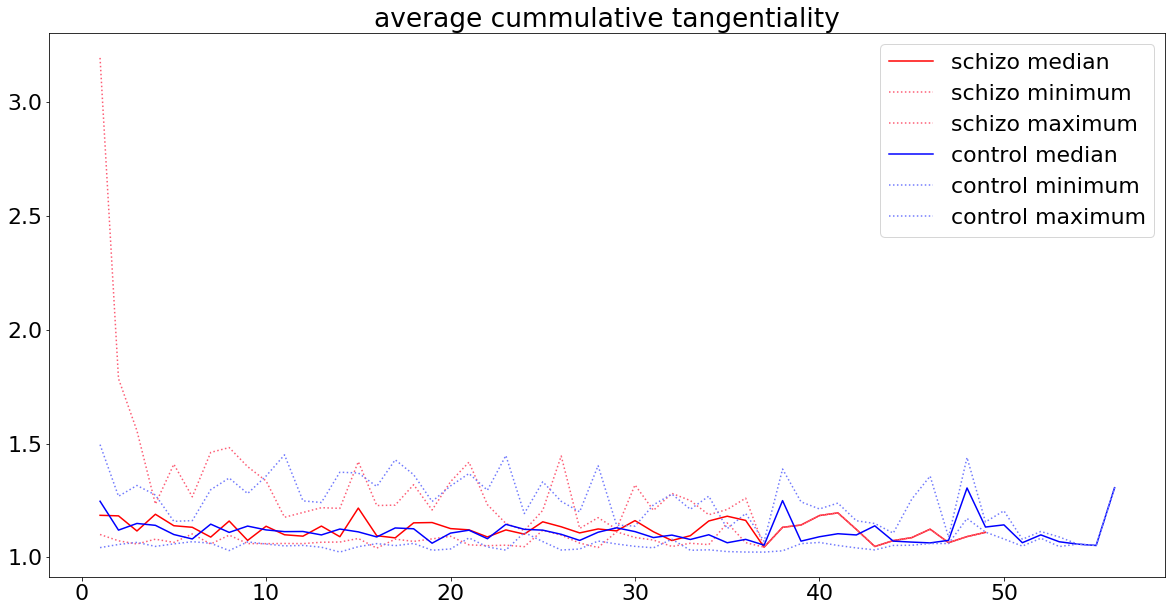

In [33]:
schizo_sim_array = []
for filename in sample['schizo']:
    file = sample['schizo'][filename]
    schizo_sim_array.append(get_cumulative_tangentiality_array(file))
schizo_average_dict = average_text_vector_dict(schizo_sim_array)
plot_average(schizo_average_dict, labels={'med':'schizo median', 'min':'schizo minimum', 'max':'schizo maximum'})

control_sim_array = []
for filename in sample['control']:
    file = sample['control'][filename]
    control_sim_array.append(get_cumulative_tangentiality_array(file))
control_average_dict = average_text_vector_dict(control_sim_array)
plot_average(control_average_dict, labels={'med':'control median', 'min':'control minimum', 'max':'control maximum'}, 
             colors={'med':'b', 'min':'#717afd', 'max':'#717afd'}, title='average cummulative tangentiality')

__let us calculate how tangential the last clause is to the whole of the story__<br>
__let us also calculate the average cumulative tangentiality of each story__

In [65]:
patient_last_cum_tan = {'control':[], 'schizo':[]}
patient_average_cum_tan = {'control':[], 'schizo':[]}
last_cum_tan_series = []
average_cum_tan_series = []
for i in patient_df.index:
    filename = patient_df.at[i, 'ID']
    group = patient_df.at[i, 'group']
    file = sample[group][filename]
    file_sim = get_cumulative_tangentiality_array(file)
    last_cum_tan_series.append(file_sim[-1])
    average_cum_tan_series.append(np.mean(file_sim))
    patient_last_cum_tan[group].append(file_sim[-1])
    patient_average_cum_tan[group].append(np.mean(file_sim))

__let us plot the cummulative tangentiality of the last clause for each patient in each group by their rank__

Text(0.5, 0, 'patient rank on cumulative tangentiality of the last clause')

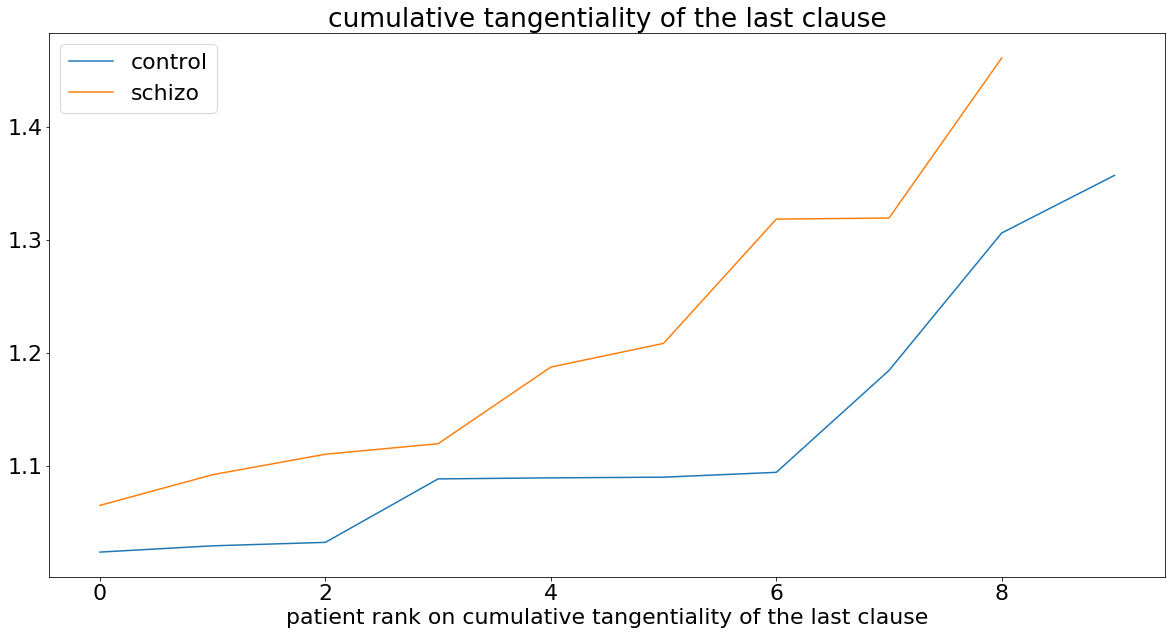

In [64]:
plt.plot(sorted(patient_last_cum_tan['control']), label='control')
plt.plot(sorted(patient_last_cum_tan['schizo']), label='schizo')
plt.legend()
plt.title(label='cumulative tangentiality of the last clause')
plt.xlabel('patient rank on cumulative tangentiality of the last clause')

__let us plot the average cumulative tangentiality for each patient in each group (by rank)__

Text(0.5, 0, 'patient rank on average cumulative tangentiality')

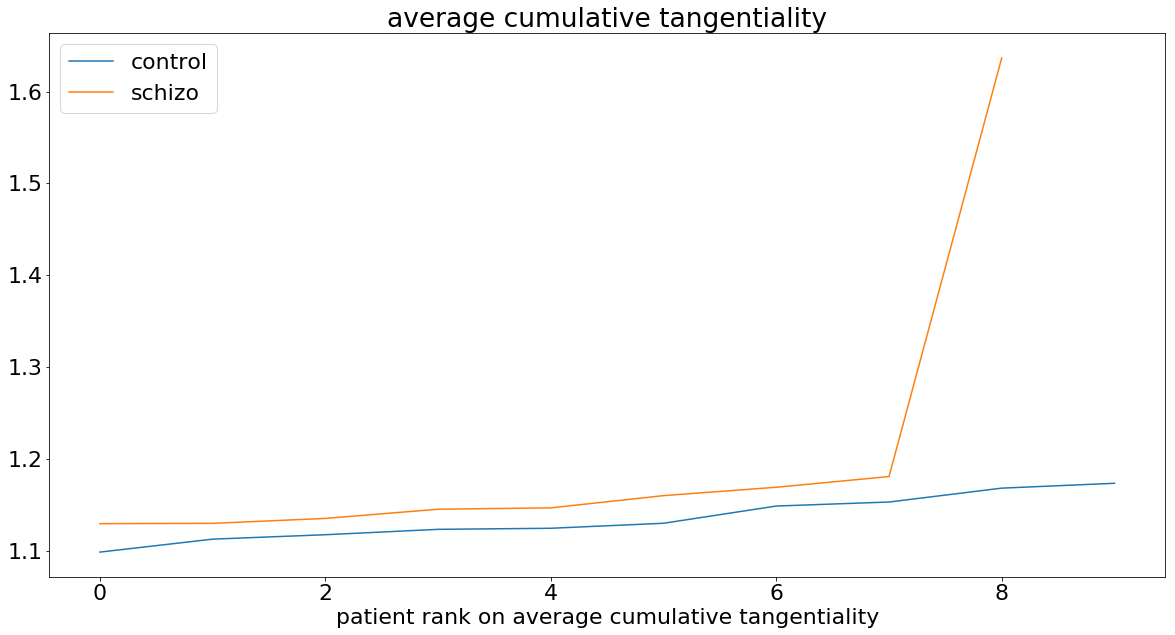

In [66]:
plt.plot(sorted(patient_average_cum_tan['control']), label='control')
plt.plot(sorted(patient_average_cum_tan['schizo']), label='schizo')
plt.legend()
plt.title(label='average cumulative tangentiality')
plt.xlabel('patient rank on average cumulative tangentiality')

__the last schizo patient's story is too tangential! <br>
let us see the picture without the first patient from schizo group!__

Text(0.5, 0, 'patient rank on average cumulative tangentiality')

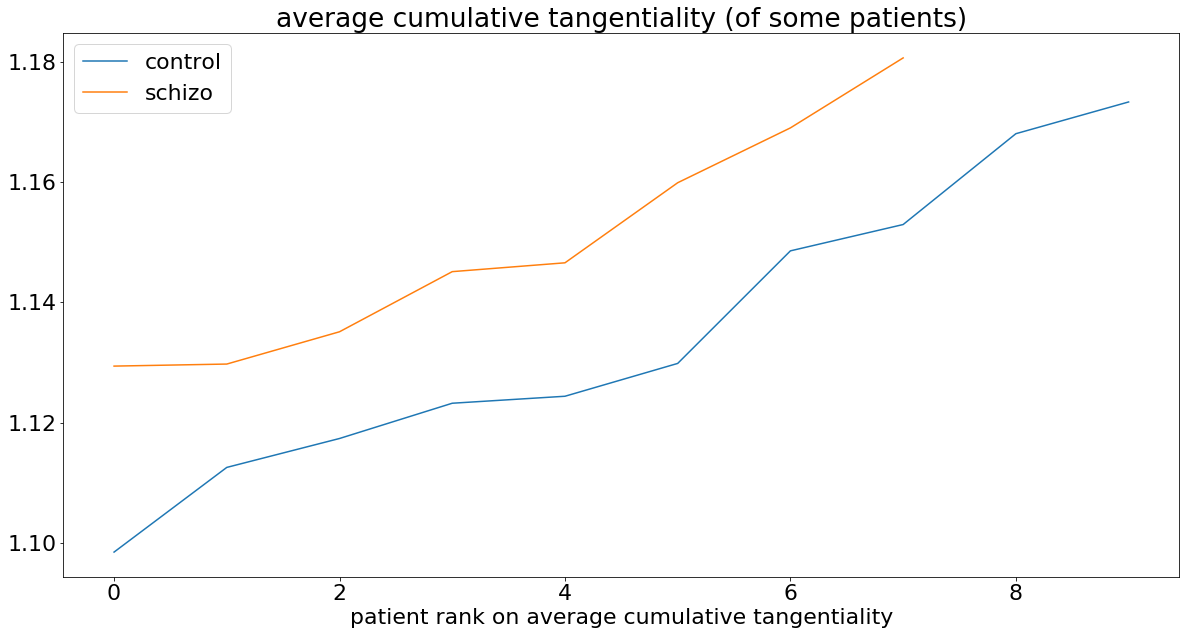

In [68]:
plt.plot(sorted(patient_average_cum_tan['control']), label='control')
plt.plot(sorted(patient_average_cum_tan['schizo'])[:-1], label='schizo')
plt.legend()
plt.title(label='average cumulative tangentiality (of some patients)')
plt.xlabel('patient rank on average cumulative tangentiality')

### Local coherence
<ul>
    <li>a plot: <br>
        x axis: number of the current clause <br>
        y axis: cosine distance between an averaged vector of the neighbouring clauses</li>
</ul>

In [34]:
def get_local_coherence_array(clauses):
    clause_vectors = get_file_clause_vectors(clauses)
    local_coherence_array = []
    length = len(clause_vectors)
    for i in range(length-1):
        local_coherence_array.append(cos_sim(clause_vectors[i], clause_vectors[i+1]))
    return [1/x for x in local_coherence_array]

__let us plot local coherence of both groups__

Text(0.5, 1.0, 'local coherence of control texts')

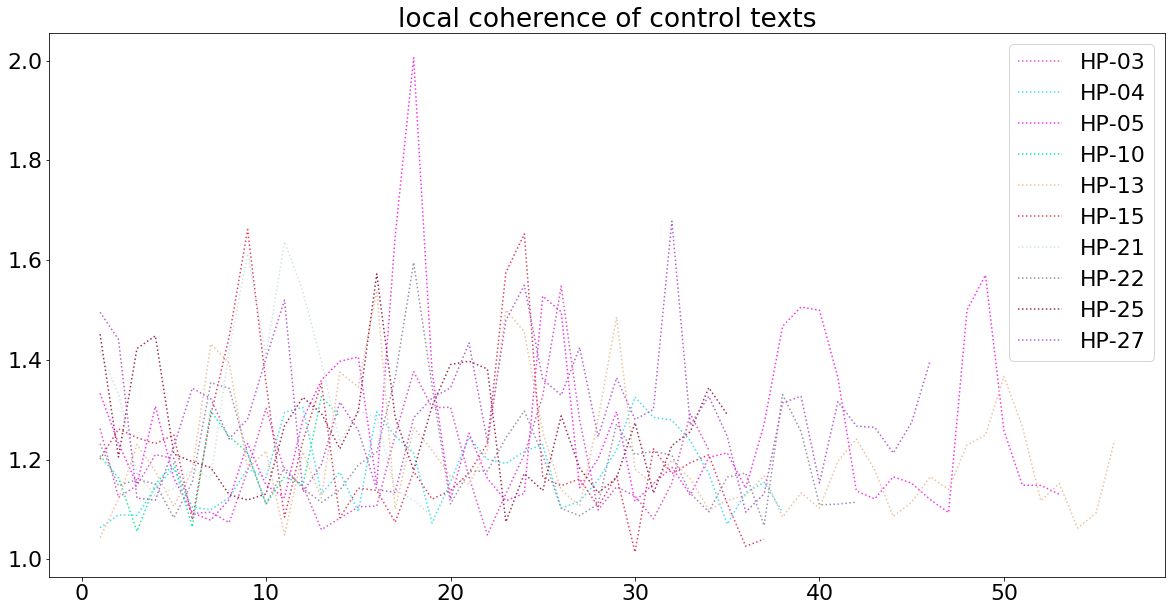

In [35]:
for filename in sample['control']:
    file = sample['control'][filename]
    local_coherence_array = get_local_coherence_array(file)
    plt.plot(np.arange(len(local_coherence_array))+1, local_coherence_array, color=random_color(), label=filename, linestyle=':')
plt.legend()
plt.rcParams.update({'font.size': 22, 'figure.figsize':[20,10]})
plt.title(label='local coherence of control texts')

Text(0.5, 1.0, 'local coherence of schizo texts')

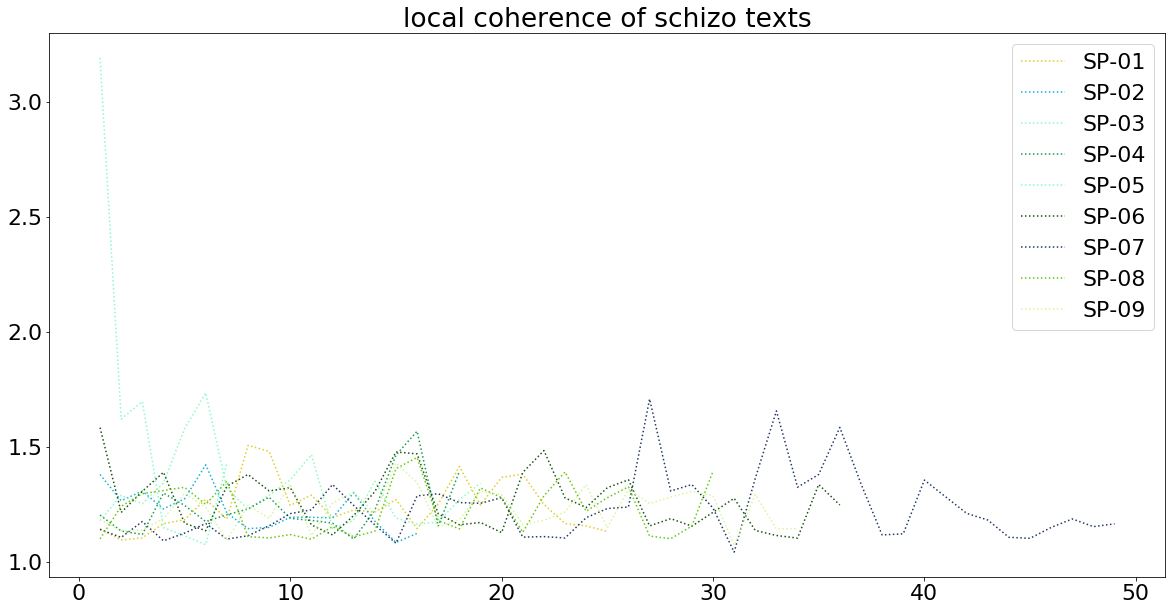

In [36]:
for filename in sample['schizo']:
    file = sample['schizo'][filename]
    local_coherence_array = get_local_coherence_array(file)
    plt.plot(np.arange(len(local_coherence_array))+1, local_coherence_array, color=random_color(), label=filename, linestyle=':')
plt.legend()
plt.rcParams.update({'font.size': 22, 'figure.figsize':[20,10]})
plt.title(label='local coherence of schizo texts')

__let us also plot the average local coherence in both groups__

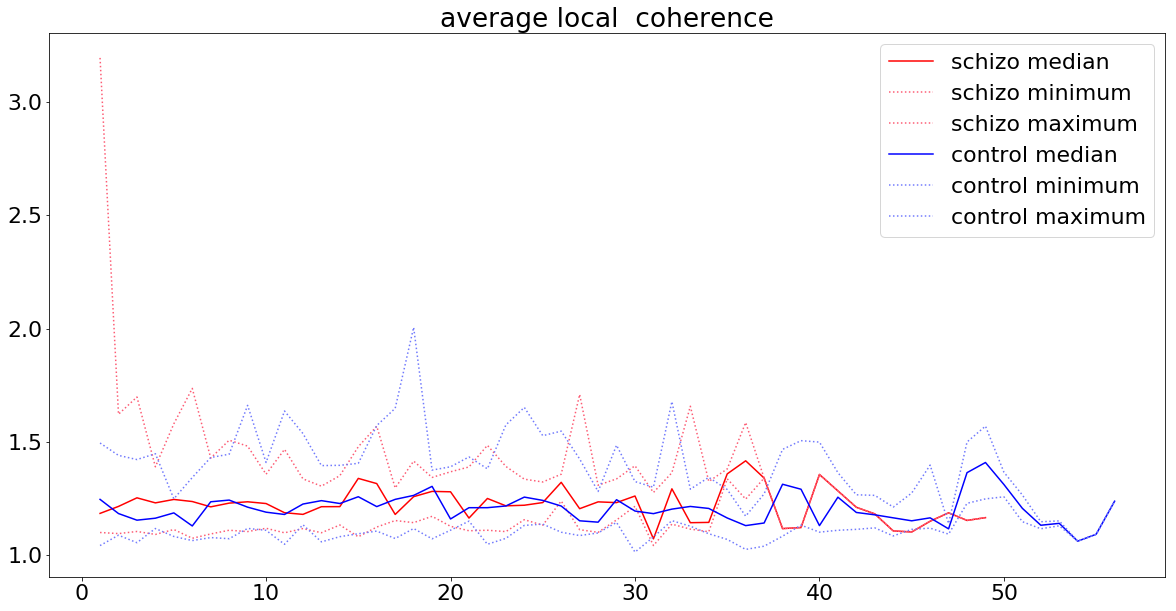

In [37]:
schizo_local_coherence_array = []
for filename in sample['schizo']:
    file = sample['schizo'][filename]
    schizo_local_coherence_array.append(get_local_coherence_array(file))
schizo_average_dict = average_text_vector_dict(schizo_local_coherence_array)
plot_average(schizo_average_dict, labels={'med':'schizo median', 'min':'schizo minimum', 'max':'schizo maximum'})

control_local_coherence_array = []
for filename in sample['control']:
    file = sample['control'][filename]
    control_local_coherence_array.append(get_local_coherence_array(file))
control_average_dict = average_text_vector_dict(control_local_coherence_array)
plot_average(control_average_dict, labels={'med':'control median', 'min':'control minimum', 'max':'control maximum'}, 
             colors={'med':'b', 'min':'#717afd', 'max':'#717afd'}, title='average local  coherence')

__let us calculate and plot the average local coherence for each patient in each group (by rank)__

In [38]:
patient_average_loc_coh = {'control':[], 'schizo':[]}
average_loc_coh_series = []
for i in patient_df.index:
    filename = patient_df.at[i, 'ID']
    group = patient_df.at[i, 'group']
    file = sample[group][filename]
    file_sim = get_local_coherence_array(file)
    average_loc_coh_series.append(np.mean(file_sim))
    patient_average_loc_coh[group].append(np.mean(file_sim))

Text(0.5, 0, 'patient rank on average local coherence')

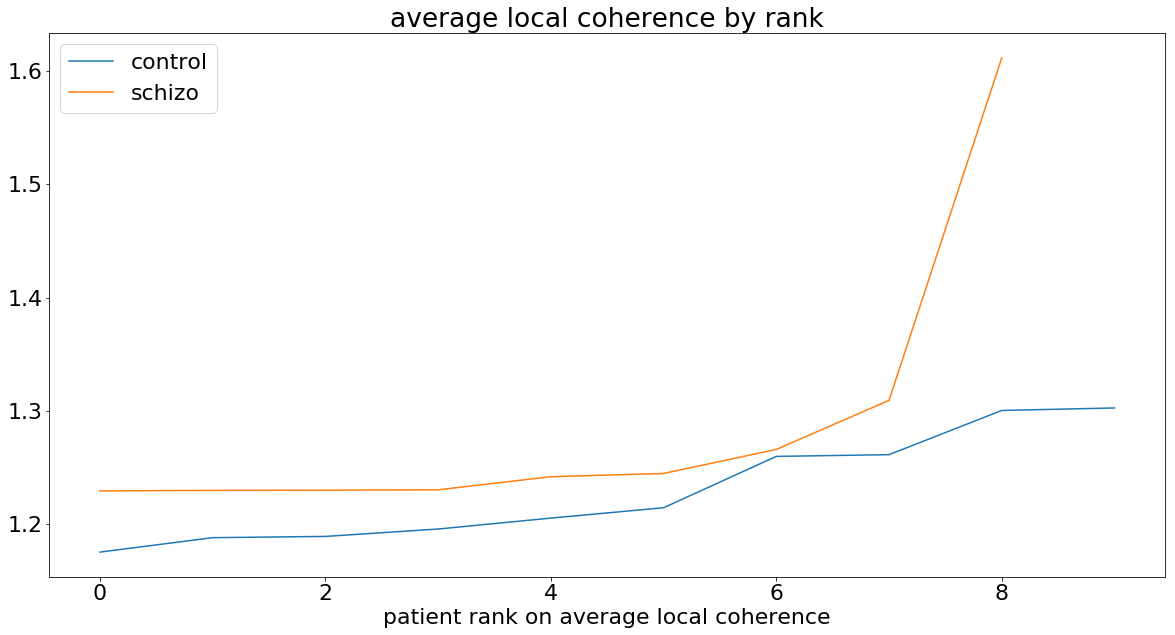

In [39]:
plt.plot(sorted(patient_average_loc_coh['control']), label='control')
plt.plot(sorted(patient_average_loc_coh['schizo']), label='schizo')
plt.legend()
plt.title(label='average local coherence by rank')
plt.xlabel('patient rank on average local coherence')

## let us now draw some ROC-curves

Text(0, 0.5, 'True Positive Rate')

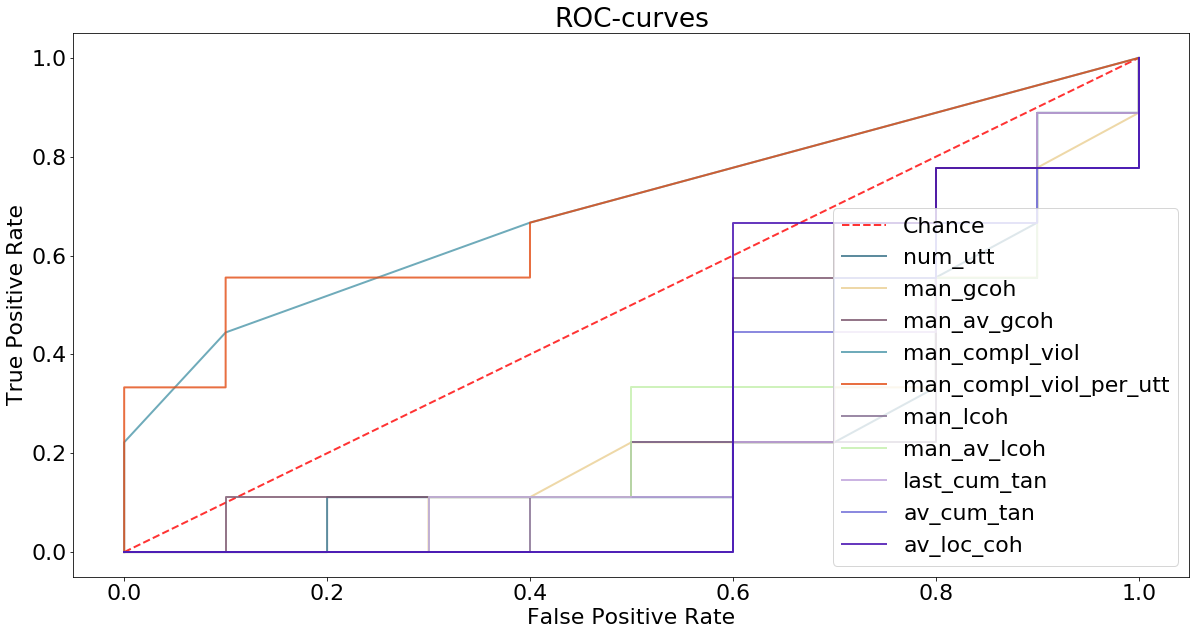

In [40]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
for col in patient_df.keys()[3:]:
    y = patient_df['diagnosis']
    x = patient_df[col]
    fpr, tpr, thresholds = metrics.roc_curve(y, x, pos_label=1)
    plt.plot(fpr, tpr, label=col, lw=2, alpha=.8, color=random_color())
plt.legend(loc='lower right')
plt.title(label='ROC-curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [168]:
for col in patient_df.keys()[3:]:
    y = patient_df['diagnosis']
    x = patient_df[col]
    print(col, metrics.roc_auc_score(y, x))

num_utt 0.7555555555555555
man_gcoh 0.7555555555555555
man_av_gcoh 0.6555555555555556
man_compl_viol 0.7
man_compl_viol_per_utt 0.7
man_lcoh 0.7777777777777778
man_av_lcoh 0.7222222222222222
last_cum_tan 0.7444444444444445
av_cum_tan 0.7555555555555555
av_loc_coh 0.711111111111111


## let us try some machine learning
__C-Support Vector Classification, to be exact__

__let us split the sample__

In [49]:
array_all = patient_df.values[:,2:]
X = [list(x) for x in array_all[:, 1:]]
y = list(array_all[:, 0])

In [50]:
scores = ['accuracy', 'precision', 'recall', 'f1']
kernels = ['linear', 'rbf']
loo = LeaveOneOut()

### let us see some metrics and visually compare these

In [53]:
def manual_fit_cv(cvs, clf):
    fits = {}
    for scoring in scores:
        fits[scoring] = []
        for cv in cvs:
            fit_scores = cross_val_score(clf, X, y, cv=cv, scoring=scoring)
            fits[scoring].append({'mean' : fit_scores.mean(), 'std' : fit_scores.std()})
    return fits

In [54]:
k_fit_cv = {}
for kernel in kernels:
    clf = svm.SVC(kernel=kernel, C=10, gamma='scale')
    k_fit_cv[kernel] = manual_fit_cv(range(3,7), clf)

k_fit_cv

{'linear': {'accuracy': [{'mean': 0.6825396825396824,
    'std': 0.022447834323382487},
   {'mean': 0.5666666666666667, 'std': 0.07071067811865474},
   {'mean': 0.5166666666666667, 'std': 0.20682789409984761},
   {'mean': 0.638888888888889, 'std': 0.21872244094477256}],
  'precision': [{'mean': 0.7555555555555555, 'std': 0.17497795275581804},
   {'mean': 0.41666666666666663, 'std': 0.24999999999999997},
   {'mean': 0.36666666666666664, 'std': 0.30550504633038933},
   {'mean': 0.47222222222222215, 'std': 0.36535962327683075}],
  'recall': [{'mean': 0.6666666666666666, 'std': 0.2721655269759087},
   {'mean': 0.5416666666666666, 'std': 0.36084391824351614},
   {'mean': 0.5, 'std': 0.4472135954999579},
   {'mean': 0.5833333333333334, 'std': 0.44876373392787533}],
  'f1': [{'mean': 0.6388888888888888, 'std': 0.10393492741038722},
   {'mean': 0.4583333333333333, 'std': 0.27322660517925},
   {'mean': 0.42000000000000004, 'std': 0.36},
   {'mean': 0.5166666666666667, 'std': 0.39334745737353155

In [56]:
def manual_fit_loo(clf):
    for scoring in scores:
        scores_3 = cross_val_score(clf, X, y, cv=3, scoring=scoring)
        scores_loo = cross_val_score(clf, X, y, cv=loo, scoring=scoring)
        print(scoring, '3-fold', scores_3.mean(), 'loo', scores_loo.mean())

    all_1 = np.ones_like(y)
    accuracy_loo = cross_val_score(clf, X, y, cv=loo)
    print('loo total (p/r/f1)',
          metrics.precision_score(accuracy_loo, all_1),
          metrics.recall_score(accuracy_loo, all_1),
          metrics.f1_score(accuracy_loo, all_1))

### let us automatically fit these
source code for this part  [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py)<br>
don't blame me: we all copy-paste, and I even thougth while doing it

In [203]:
best_parametrs = {}
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=0)

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=5,
                       scoring=score)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    best_parametrs[score] = clf.best_params_
    
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for accuracy



c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.526 (+/-0.122) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.526 (+/-0.122) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.526 (+/-0.122) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.526 (+/-0.122) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.632 (+/-0.497) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.526 (+/-0.122) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.684 (+/-0.482) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.632 (+/-0.497) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.684 (+/-0.482) for {'C': 1, 'kernel': 'linear'}
0.632 (+/-0.399) for {'C': 10, 'kernel': 'linear'}
0.579 (+/-0.388) for {'C': 100, 'kernel': 'linear'}
0.526 (+/-0.260) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

           

c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.579 (+/-0.987) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.789 (+/-0.815) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.579 (+/-0.987) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.789 (+/-0.815) for {'C': 1, 'kernel': 'linear'}
0.711 (+/-0.815) for {'C': 10, 'kernel': 'linear'}
0.605 (+/-0.766) for {'C': 100, 'kernel': 'linear'}
0.298 (+/-0.547) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

           

c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.368 (+/-0.714) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.474 (+/-0.605) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.368 (+/-0.714) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.474 (+/-0.605) for {'C': 1, 'kernel': 'linear'}
0.474 (+/-0.605) for {'C': 10, 'kernel': 'linear'}
0.474 (+/-0.605) for {'C': 100, 'kernel': 'linear'}
0.474 (+/-0.887) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

           

c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [193]:
best_parametrs

{'accuracy': {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'},
 'precision': {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'},
 'recall': {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'},
 'f1': {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}}

### let us manually fit these again

In [55]:
clf = svm.SVC(kernel='rbf', gamma=0.001, C = 1000)
manual_fit_loo(clf)

accuracy 3-fold 0.4682539682539682 loo 0.631578947368421
precision 3-fold 0.4444444444444444 loo 0.2631578947368421
recall 3-fold 0.4444444444444444 loo 0.2631578947368421
f1 3-fold 0.43492063492063493 loo 0.2631578947368421
loo total (p/r/f1) 0.631578947368421 1.0 0.7741935483870968


{}

In [75]:
clf = svm.SVC(kernel='rbf', gamma=0.001, C = 1000)
final_fit_cv = manual_fit_cv(range(2,7), clf)
final_fit_cv

{'accuracy': [{'mean': 0.5222222222222221, 'std': 0.07777777777777778},
  {'mean': 0.4682539682539682, 'std': 0.09976035785695662},
  {'mean': 0.5125, 'std': 0.1948557158514987},
  {'mean': 0.45, 'std': 0.29154759474226505},
  {'mean': 0.5, 'std': 0.3818813079129867}],
 'precision': [{'mean': 0.5, 'std': 0.5},
  {'mean': 0.4444444444444444, 'std': 0.07856742013183862},
  {'mean': 0.41666666666666663, 'std': 0.24999999999999997},
  {'mean': 0.26666666666666666, 'std': 0.38873012632302006},
  {'mean': 0.3333333333333333, 'std': 0.4714045207910317}],
 'recall': [{'mean': 0.1, 'std': 0.1},
  {'mean': 0.4444444444444444, 'std': 0.15713484026367722},
  {'mean': 0.4583333333333333, 'std': 0.36084391824351614},
  {'mean': 0.3, 'std': 0.4},
  {'mean': 0.3333333333333333, 'std': 0.4714045207910317}],
 'f1': [{'mean': 0.16666666666666669, 'std': 0.16666666666666669},
  {'mean': 0.43492063492063493, 'std': 0.10028932697734172},
  {'mean': 0.42500000000000004, 'std': 0.2861380785564899},
  {'mean':

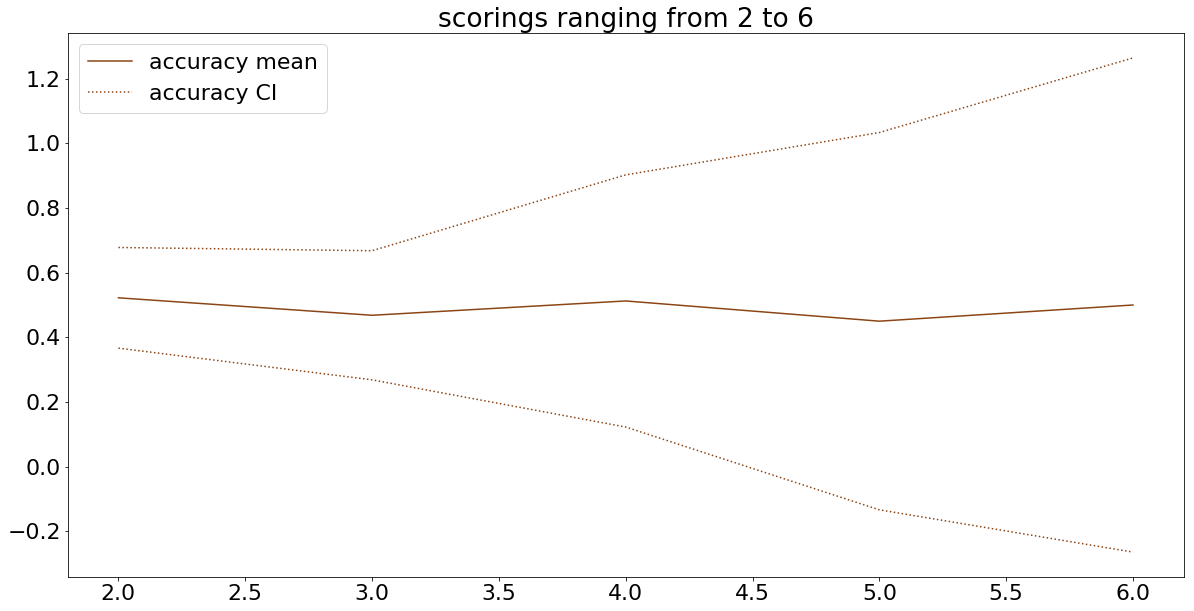

In [81]:
scoring = 'accuracy'
color = random_color()
current = final_fit_cv[scoring]
means = [d['mean'] for d in current]
mins = [d['mean']-2*d['std'] for d in current]
maxs = [d['mean']+2*d['std'] for d in current]
plt.plot(np.arange(5)+2, means, color=color, label='%s mean'%(scoring), linestyle='-')
plt.plot(np.arange(5)+2, mins, color=color, label='%s CI'%(scoring), linestyle=':')
plt.plot(np.arange(5)+2, maxs, color=color, linestyle=':')
plt.title(label='scorings ranging from 2 to 6')
plt.legend()

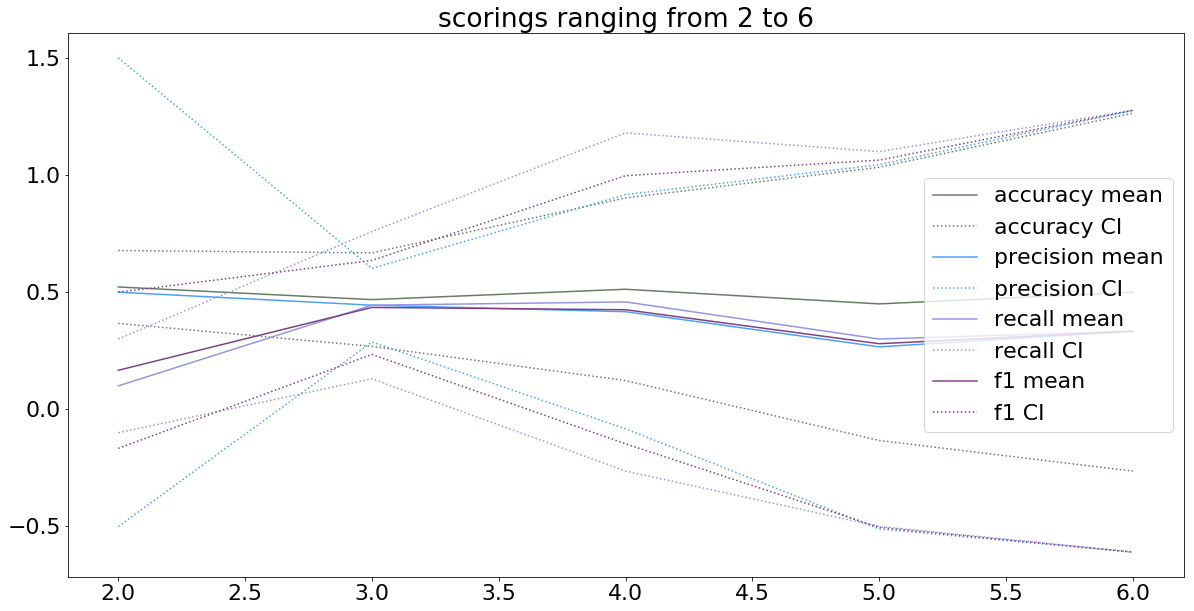

In [82]:
for scoring in scores:
    color = random_color()
    current = final_fit_cv[scoring]
    means = [d['mean'] for d in current]
    mins = [d['mean']-2*d['std'] for d in current]
    maxs = [d['mean']+2*d['std'] for d in current]
    plt.plot(np.arange(5)+2, means, color=color, label='%s mean'%(scoring), linestyle='-')
    plt.plot(np.arange(5)+2, mins, color=color, label='%s CI'%(scoring), linestyle=':')
    plt.plot(np.arange(5)+2, maxs, color=color, linestyle=':')
plt.title(label='scorings ranging from 2 to 6')
plt.legend()